In [19]:
ROOT_PATH = '../../../../'
MNIST_DATA_PATH = ROOT_PATH + 'assets/data/morphomnist/class_conditional_38_binarised/'
BASE_LOG_PATH = ROOT_PATH + 'SVIExtensionExperiment/'  # '/None/'

# Setup

In [20]:
%matplotlib inline
import sys
import os

sys.path.append(ROOT_PATH)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import pyro
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import inspect
from collections import OrderedDict
from functools import partial
import torch

import traceback
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

torch.autograd.set_grad_enabled(False);

In [32]:
from deepscm.datasets.morphomnist import MorphoMNISTLike

test_data = MorphoMNISTLike(MNIST_DATA_PATH, train=False, columns=['thickness', 'intensity'])

In [22]:
from deepscm.morphomnist import measure

In [5]:
df = pd.read_csv(f'{MNIST_DATA_PATH}t10k-morpho.csv')

In [207]:
from deepscm.submodules.morphomnist.morphomnist import io, morpho, perturb
from deepscm.datasets.morphomnist import load_morphomnist_like, save_morphomnist_like

train_data_path = f'{ROOT_PATH}assets/data/morphomnist/class_conditional_38_binarised/'
train_images, train_labels, train_metrics = load_morphomnist_like(train_data_path, train=False)

test_data_path = f'{ROOT_PATH}assets/data/morphomnist/class_conditional_38_binarised_i_100/'
test_images, test_labels, test_metrics = load_morphomnist_like(test_data_path, train=False)

In [159]:
%%bash
cat "../../../../assets/data/morphomnist/class_conditional_38_binarised_i_100/args.txt"

Generated data for:
 {'data_dir': 'assets/data/morphomnist/class_conditional_38_binarised', 'out_dir': 'assets/data/morphomnist/class_conditional_38_binarised_i_100', 'train': False, 'thickness_af': 0, 'intensity_af': 100.0}


(<matplotlib.image.AxesImage at 0x7fce09ed17c0>,
        thickness   intensity
 index                       
 0       2.775013  188.275700
 1       3.253965  210.476395
 2       3.257630  211.120834
 3       4.824276  305.341810
 4       4.836808  255.117310
 ...          ...         ...
 1979    3.184955  208.431290
 1980    4.864513  314.912640
 1981    2.837090  186.924580
 1982    4.266907  240.887240
 1983    4.883452  317.576580
 
 [1984 rows x 2 columns])

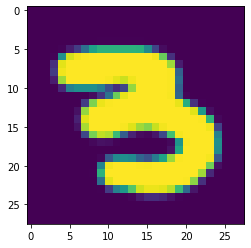

In [7]:
plt.imshow(test_images[4]), test_metrics

(<matplotlib.image.AxesImage at 0x7fce09dead00>,
        thickness   intensity
 index                       
 0       1.892117   88.275700
 1       2.068905  110.476395
 2       2.475651  111.120834
 3       2.731961  205.341810
 4       2.413131  155.117310
 ...          ...         ...
 1979    2.147315  108.431290
 1980    3.082784  214.912640
 1981    1.708498   86.924580
 1982    2.592157  140.887240
 1983    3.088629  217.576580
 
 [1984 rows x 2 columns])

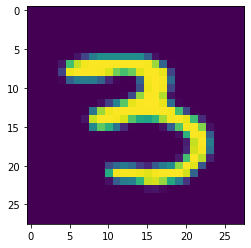

In [8]:
plt.imshow(train_images[4]), train_metrics

In [24]:
# from deepscm.datasets.morphomnist.create_synth_thickness_intensity_data import model as true_model
from deepscm.experiments import morphomnist_reversed_arrows
from deepscm.experiments.morphomnist_binary_labels.base_experiment import EXPERIMENT_REGISTRY, MODEL_REGISTRY

In [69]:
def prep_data(batch):
    x = batch['image']
    thickness = batch['thickness'].unsqueeze(0).float()
    intensity = batch['intensity'].unsqueeze(0).float()

    x = x.float()

    x = x.unsqueeze(0).unsqueeze(0)

    return {'x': x, 'thickness': thickness, 'intensity': intensity}

In [103]:
from deepscm.morphomnist import measure
import multiprocessing

def measure_image(x, threshold=0.5, use_progress_bar=True):
    imgs = x.detach().cpu().numpy()[:, 0]

    with multiprocessing.Pool() as pool:
        measurements = measure.measure_batch(imgs, threshold=threshold, pool=pool)

    def get_intensity(imgs, threshold):

        img_min, img_max = imgs.min(axis=(1, 2), keepdims=True), imgs.max(axis=(1, 2), keepdims=True)
        mask = (imgs >= img_min + (img_max - img_min) * threshold)

        return np.array([np.median(i[m]) for i, m in zip(imgs, mask)])

    return measurements['thickness'].values, get_intensity(imgs, threshold)

In [207]:
from deepscm.submodules.morphomnist.morphomnist import io, morpho, perturb

images = io.load_idx(f'{MNIST_DATA_PATH}t10k-images-idx3-ubyte.gz')

# Metrics

In [153]:
#, 'ConditionalClassReversedVISEM', 'ConditionalClassReversedVISEM']
versions = [131, 132, 133, 134, 135, 136, 138, 140]  # , 6, 8]
experiments = ['ConditionalClassReversedVISEM'] * len(versions)

# Load Models

In [154]:
models = {} # {'true': true_model,}

loaded_models = {}

for v, exp in zip(versions, experiments):
    try:
        checkpoint_path = f'{BASE_LOG_PATH}/{exp}/version_{v}/'

        base_path = os.path.join(checkpoint_path, 'checkpoints')
        checkpoint_path = os.path.join(base_path, os.listdir(base_path)[0])

        ckpt = torch.load(checkpoint_path, map_location=torch.device('cuda'))
        hparams = ckpt['hyper_parameters']
        print(v, hparams['denoising'], hparams['latent_dim'], hparams['num_svi_particles'])
        
        model_class = MODEL_REGISTRY[hparams['model']]

        model_params = {
            k: v for k, v in hparams.items() if (
                k in inspect.signature(model_class.__init__).parameters
                or k in k in inspect.signature(model_class.__bases__[0].__init__).parameters
                or k in k in inspect.signature(model_class.__bases__[0].__bases__[0].__init__).parameters
            )
        }
        
        new_state_dict = OrderedDict()

        for key, value in ckpt['state_dict'].items():
            new_key = key.replace('pyro_model.', '')
            new_state_dict[new_key] = value
            
        loaded_model = model_class(**model_params)
        loaded_model.load_state_dict(new_state_dict)
        
        for p in loaded_model._buffers.keys():
            if 'norm' in p:
                setattr(loaded_model, p, getattr(loaded_model, p))
                
        loaded_model.eval()
                
                
        loaded_models[v] = loaded_model
        
        def sample_pgm(num_samples, model):
            with pyro.plate('observations', num_samples):
                return model.pgm_model()
        
        models[v] = partial(sample_pgm, model=loaded_model)
    except Exception as e:
        print(e)
        traceback.print_exc()

131 True 16 4
132 True 8 4
133 False 16 4
134 False 8 4
135 False 8 8
136 False 8 8
138 False 8 32
140 False 4 16


In [106]:
def prep_data(batch):
    x = batch['image']
    thickness = batch['thickness'].unsqueeze(-1).float()
    intensity = batch['intensity'].unsqueeze(-1).float()
    label = batch['label'].unsqueeze(-1).float()
    x = x.float()
    x = x.unsqueeze(1)
    return {'x': x, 'thickness': thickness, 'intensity': intensity, 'label': label}

In [ ]:
batch['label'].unsqueeze(-1).float()

In [27]:
def get_counterfactuals_conds(labels):
    return {
        'do(i + 75)': {'intensity': intensity + 100},
        'do(i - 75)': {'intensity': intensity - 75},
        'do(t + 2)': {'thickness': thickness + 2},
        'do(t - 2)': {'thickness': thickness - 1.5},
    }

In [181]:
(np.random.random(size=(1000, 1, 28, 28)) - np.random.random(size=(1000, 1, 28, 28))).mean()

0.0001818020158768123

In [186]:
preds = np.load(f'{ROOT_PATH}/ConditionalClassReversedVISEM_version_{version}_{cond}.npy')
test_data_path = f'{ROOT_PATH}assets/data/morphomnist/class_conditional_38_binarised{test_set}/'
true, _, _ = load_morphomnist_like(test_data_path, train=False)
print(np.squeeze(preds, 1).shape, true.shape)
(true - preds).shape

(1984, 28, 28) (1984, 28, 28)


(1984, 1984, 28, 28)

In [203]:
conds = ['recon', 'do(i + 75)', 'do(i - 75)', 'do(t + 2)', 'do(t - 2)']
test_sets = ['', '_i_100', '_i_m_75', '_t_2', '_t_m_1_5']


for cond, test_set in zip(conds, test_sets):
    for version, model in loaded_models.items():
        preds = np.load(f'{ROOT_PATH}/ConditionalClassReversedVISEM_version_{version}_{cond}.npy')
        test_data_path = f'{ROOT_PATH}assets/data/morphomnist/class_conditional_38_binarised{test_set}/'
        true, _, _ = load_morphomnist_like(test_data_path, train=False)
        preds = np.squeeze(preds, 1).reshape(1984, -1)
        preds[np.isnan(preds)] = 0
        loss = torch.nn.functional.l1_loss(
            torch.tensor(preds),
            torch.tensor(true.reshape(1984, -1))
        )
        print(version, cond, loss)

recon
131 recon tensor(5.8890)
132 recon tensor(8.6683)
133 recon tensor(5.7618)
134 recon tensor(8.7310)
135 recon tensor(8.4417)
136 recon tensor(8.8070)
138 recon tensor(9.5435)
140 recon tensor(13.0679)
do(i + 75)
131 do(i + 75) tensor(17.3898)
132 do(i + 75) tensor(20.2999)
133 do(i + 75) tensor(19.4516)
134 do(i + 75) tensor(21.1384)
135 do(i + 75) tensor(22.5301)
136 do(i + 75) tensor(20.0565)
138 do(i + 75) tensor(21.6418)
140 do(i + 75) tensor(24.9366)
do(i - 75)
131 do(i - 75) tensor(7.3594)
132 do(i - 75) tensor(8.9675)
133 do(i - 75) tensor(8.0844)
134 do(i - 75) tensor(9.5332)
135 do(i - 75) tensor(10.2240)
136 do(i - 75) tensor(9.0501)
138 do(i - 75) tensor(9.8830)
140 do(i - 75) tensor(11.8272)
do(t + 2)
131 do(t + 2) tensor(14.3519)
132 do(t + 2) tensor(17.8558)
133 do(t + 2) tensor(14.6758)
134 do(t + 2) tensor(18.6324)
135 do(t + 2) tensor(37.7916)
136 do(t + 2) tensor(17.8922)
138 do(t + 2) tensor(20.4362)
140 do(t + 2) tensor(23.8079)
do(t - 2)
131 do(t - 2) tensor(

In [107]:
from collections import defaultdict

batch_size = 10
data_len = 11 # len(test_data)
batches = data_len // batch_size
model_name = 'ConditionalClassReversedVISEM'

cfs = defaultdict(float)

for i in range(batches + 1):
    print(i)
    
    lb = i * batch_size
#     if i == batches:
#         ub = len(test_data)
#     else:
    ub = i * batch_size + batch_size
    batch = prep_data(test_data[lb:ub])
    print(batch['x'].shape)
    
    cf_conds = get_counterfactuals_conds(batch['x'], batch['intensity'], batch['thickness'])
    
    # recons = loaded_models[model_name].reconstruct(**batch, num_particles=hparams['num_sample_particles'])
    # cfs['mae'] += np.abs((recons - batch['x'])).reshape(ub - lb, -1).mean(axis=1).sum()
    
    cfs_intensity_1 = loaded_models[model_name].counterfactual(
        obs=batch, condition=cf_conds['do(i + 75)'], num_particles=1) # hparams['num_sample_particles'])
#     cfs_intensity_2 = loaded_models[model_name].counterfactual(
#         obs=batch, condition=cf_conds['do(i - 75)'], num_particles=hparams['num_sample_particles'])
#     cfs_thickness_1 = loaded_models[model_name].counterfactual(
#         obs=batch, condition=cf_conds['do(t + 2)'], num_particles=hparams['num_sample_particles'])
#     cfs_thickness_2 = loaded_models[model_name].counterfactual(
#         obs=batch, condition=cf_conds['do(t - 2)'], num_particles=hparams['num_sample_particles'])
    
#     cfs_comb = np.vstack([
#         cfs_intensity_1['x'],
#         cfs_intensity_2['x'],
#         cfs_thickness_1['x'],
#         cfs_thickness_2['x']
#     ])
    
#     preds = measure_image(torch.tensor(cfs_comb))
    
#     thickness_pred = preds[0].reshape(-1, ub - lb)
#     intensity_pred = preds[1].reshape(-1, ub - lb)
    
#     int_mae_1 = np.abs(cf_conds['do(i + 75)']['intensity'].flatten() - np.nan_to_num(intensity_pred[0])).sum()
#     int_mae_2 = np.abs(cf_conds['do(i - 75)']['intensity'].flatten() - np.nan_to_num(intensity_pred[1])).sum()
#     thick_mae_1_measure = np.abs(cf_conds['do(t + 2)']['thickness'].flatten() - np.nan_to_num(thickness_pred[2])).sum()
#     thick_mae_2_measure = np.abs(cf_conds['do(t - 2)']['thickness'].flatten() - np.nan_to_num(thickness_pred[3])).sum()
    
#     cfs['do(i + 75)'] += int_mae_1
#     cfs['do(i - 75)'] += int_mae_2
#     cfs['do(t + 2)_measure'] += thick_mae_1_measure
#     cfs['do(t - 2)_measure'] += thick_mae_2_measure
    
#     t_1 = cfs_thickness_1['x'].squeeze(1).numpy()
#     t_2 = cfs_thickness_2['x'].squeeze(1).numpy()
#     thick_mae_1 = (thickened_images[lb:ub] - t_1).reshape(ub - lb, -1).sum() / 255
#     thick_mae_2 = (thinned_images[lb:ub] - t_2).reshape(ub - lb, -1).sum() / 255
#     cfs['do(t + 2)'] += thick_mae_1
#     cfs['do(t - 2)'] += thick_mae_2
    
#     print(int_mae_1, int_mae_2, thick_mae_1_measure, thick_mae_2_measure, thick_mae_1, thick_mae_2)

# for k in cfs.keys():
#     cfs[k] /= data_len

0
torch.Size([10, 1, 28, 28])
1
torch.Size([10, 1, 28, 28])


In [228]:
batch = prep_data(test_data[lb:ub])
print(batch['label'])
print((~batch['label'].bool()).float())

tensor([[[0., 0., 0., 1., 0., 1., 1., 0., 1., 0.]]])
tensor([[[1., 1., 1., 0., 1., 0., 0., 1., 0., 1.]]])


In [254]:
def get_counterfactuals_labels(label):
    return {'label': (~label.bool()).float()}

def prep_data(batch):
    x = batch['image']
    thickness = batch['thickness'].unsqueeze(-1).float()
    intensity = batch['intensity'].unsqueeze(-1).float()
    label = batch['label'].unsqueeze(-1).float()
    x = x.float()
    x = x.unsqueeze(1)
    return {'x': x, 'thickness': thickness, 'intensity': intensity, 'label': label}

In [256]:
versions

[131, 132, 133, 134, 135, 136, 138, 140]

In [260]:
batch_size = 512
data_len = len(test_data)
batches = data_len // batch_size
model_name = 'ConditionalClassReversedVISEM'

# cfs = []

# v = 131

for v in versions:
    cfs = []
    for i in range(batches + 1):
        print(i)

        lb = i * batch_size
        if i == batches:
            ub = data_len
        else:
            ub = i * batch_size + batch_size
        batch = prep_data(test_data[lb:ub])
        cf_conds_labels = get_counterfactuals_labels(batch['label'])
        cfs_ = loaded_models[v].counterfactual(
            obs=batch, condition=cf_conds_labels, num_particles=4
        )['x']
        cfs.append(cfs_)
    cfs_dict = f'{model_name}_version_{v}_do_l'
    print(cfs[0].shape)
    print(np.concatenate(cfs).shape)
    np.save(cfs_dict, np.concatenate(cfs))

0
1
2
3
torch.Size([512, 1, 28, 28])
(1984, 1, 28, 28)
0
1
2
3
torch.Size([512, 1, 28, 28])
(1984, 1, 28, 28)
0
1
2
3
torch.Size([512, 1, 28, 28])
(1984, 1, 28, 28)
0
1
2
3
torch.Size([512, 1, 28, 28])
(1984, 1, 28, 28)
0
1
2
3
torch.Size([512, 1, 28, 28])
(1984, 1, 28, 28)
0
1
2
3
torch.Size([512, 1, 28, 28])
(1984, 1, 28, 28)
0
1
2
3
torch.Size([512, 1, 28, 28])
(1984, 1, 28, 28)
0
1
2
3
torch.Size([512, 1, 28, 28])
(1984, 1, 28, 28)


In [261]:
%%bash
git clone https://github.com/aaron-xichen/pytorch-playground.git

Cloning into 'pytorch-playground'...


In [264]:
%%bash
cd pytorch-playground/
python3 setup.py develop --user

running develop
running egg_info
creating pytorch_playground.egg-info
writing pytorch_playground.egg-info/PKG-INFO
writing dependency_links to pytorch_playground.egg-info/dependency_links.txt
writing entry points to pytorch_playground.egg-info/entry_points.txt
writing requirements to pytorch_playground.egg-info/requires.txt
writing top-level names to pytorch_playground.egg-info/top_level.txt
writing manifest file 'pytorch_playground.egg-info/SOURCES.txt'
adding license file 'LICENSE' (matched pattern 'LICEN[CS]E*')
reading manifest file 'pytorch_playground.egg-info/SOURCES.txt'
writing manifest file 'pytorch_playground.egg-info/SOURCES.txt'
running build_ext
Creating /vol/bitbucket/rrr2417/deepscm/ENV2/lib/python3.8/site-packages/pytorch-playground.egg-link (link to .)
Adding pytorch-playground 1.0.0 to easy-install.pth file
Installing quantize script to /vol/bitbucket/rrr2417/deepscm/ENV2/bin

Installed /vol/bitbucket/rrr2417/deepscm/deepscm/experiments/plotting/morphomnist_reversed_a

No local packages or working download links found for torchvision==0.4.2
error: Could not find suitable distribution for Requirement.parse('torchvision==0.4.2')


CalledProcessError: Command 'b'cd pytorch-playground/\npython3 setup.py develop --user\n'' returned non-zero exit status 1.

In [265]:
from utee import selector
model_raw, ds_fetcher, is_imagenet = selector.select('mnist')
ds_val = ds_fetcher(batch_size=10, train=False, val=True)
for idx, (data, target) in enumerate(ds_val):
    data =  Variable(torch.FloatTensor(data)).cuda()
    output = model_raw(data)

ModuleNotFoundError: No module named 'utee'

In [274]:
model_raw

NameError: name 'model_raw' is not defined

In [ ]:


for i in range(batches + 1):
    print(i)
    
    lb = i * batch_size
#     if i == batches:
#         ub = len(test_data)
#     else:
    ub = i * batch_size + batch_size
    batch = prep_data(test_data[lb:ub])
    print(batch['x'].shape)

In [55]:
cfs_intensity_1['x'].shape

torch.Size([10, 1, 28, 28])

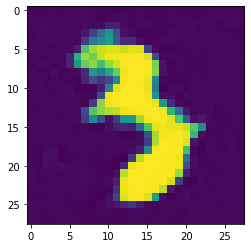

In [56]:
plt.imshow(cfs_intensity_1['x'][0].squeeze(0))

In [181]:
cfs

defaultdict(float,
            {'mae': tensor(4.4590),
             'do(i + 75)': tensor(75.4604),
             'do(i - 75)': tensor(74.5287),
             'do(t + 2)': tensor(1.8960, dtype=torch.float64),
             'do(t - 2)': tensor(2.0130, dtype=torch.float64)})

In [269]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from matplotlib import cm
cmaps = [cm.Reds, cm.Blues, cm.Greens]
img_cm = 'Greys_r'

var_name = {'thickness': 't', 'intensity': 'i', 'label': 'l'}
value_fmt = {
    'label': lambda l: rf"{int(l) if l != 0.5 else 0.5}",
    'thickness': lambda s: rf"{float(s):.1f}",
    'intensity': lambda s: rf"{int(s):d}"
}

def fmt_intervention(intervention):
    all_interventions = ', '.join([f'{var_name[k]}={value_fmt[k](v)}' for k, v in intervention.items()])
    return f"$do({all_interventions})$"

def prep_data(batch):
    x = batch['image']
    thickness = batch['thickness'].unsqueeze(0).unsqueeze(0).float()
    intensity = batch['intensity'].unsqueeze(0).unsqueeze(0).float()
    label = batch['label'].unsqueeze(0).unsqueeze(0).float()

    x = x.float()

    x = x.unsqueeze(0).unsqueeze(0)

    return {'x': x, 'thickness': thickness, 'intensity': intensity, 'label': label}

def plot_gen_intervention_range(model_name, all_interventions, save_name, normalise_all=True, num_samples=32):
    num_idx = len(all_interventions)
    num_inter = len(all_interventions[0][1])
    
    width = 16
    height = width / (1.618 * 2)
    
    hrs = [0.2 if ((i + 1) % 3) == 0 else 1 for i in range(2 * num_idx + num_idx - 1)]
    fig, ax = plt.subplots(2 * num_idx + num_idx - 1, (num_inter + 1),
                           figsize=(1.8 * (num_inter + 1), 4*num_idx),
                           gridspec_kw=dict(wspace=0, hspace=0, height_ratios=hrs))
    lim = 0
    
    for cur_ex, (idx, interventions) in enumerate(all_interventions):
        orig_data = prep_data(test_data[idx])

        imgs = []
        for intervention in interventions:
            pyro.clear_param_store()
            cond = {k: torch.tensor([[v]]) for k, v in intervention.items()}
            counterfactual = loaded_models[model_name].counterfactual(orig_data, cond, num_samples)

            imgs += [counterfactual['x']]

            diff = (orig_data['x'] - imgs[-1]).squeeze()

            lim = np.maximum(lim, diff.abs().max())
            
        x_test = orig_data['x']
        ax[cur_ex * 3, 0].imshow(x_test.squeeze(), 'Greys_r', vmin=0, vmax=255)
        ax[cur_ex * 3, 0].set_title('Original')

        for i, intervention in enumerate(interventions):
            x = imgs[i]
            
            diff = (x_test - x).squeeze()
            if not normalise_all:
                lim = diff.abs().max()

            ax[cur_ex * 3, i + 1].set_title(fmt_intervention(intervention))
            ax[cur_ex * 3, i + 1].imshow(x.squeeze(), 'Greys_r', vmin=0, vmax=255)

            ax[cur_ex * 3 + 1, i + 1].imshow(diff, 'seismic', clim=[-lim, lim])
        
        att_str = '$t={thickness}$\n$i={intensity}$'.format(
            **{att: value_fmt[att](orig_data[att].item()) for att in ('thickness', 'intensity')}
        )
        
        ax[cur_ex * 3 + 1, 0].text(0.5, 0.5, att_str, horizontalalignment='center',
                                   verticalalignment='center', transform=ax[cur_ex * 3 + 1, 0].transAxes,
                                   fontsize=mpl.rcParams['axes.titlesize'])
        
    for axi in ax.ravel():
        axi.axis('off')
        axi.xaxis.set_major_locator(plt.NullLocator())
        axi.yaxis.set_major_locator(plt.NullLocator())

    plt.savefig(f"./{save_name}.pdf", bbox_inches='tight', pad_inches=0)
        
    plt.show()

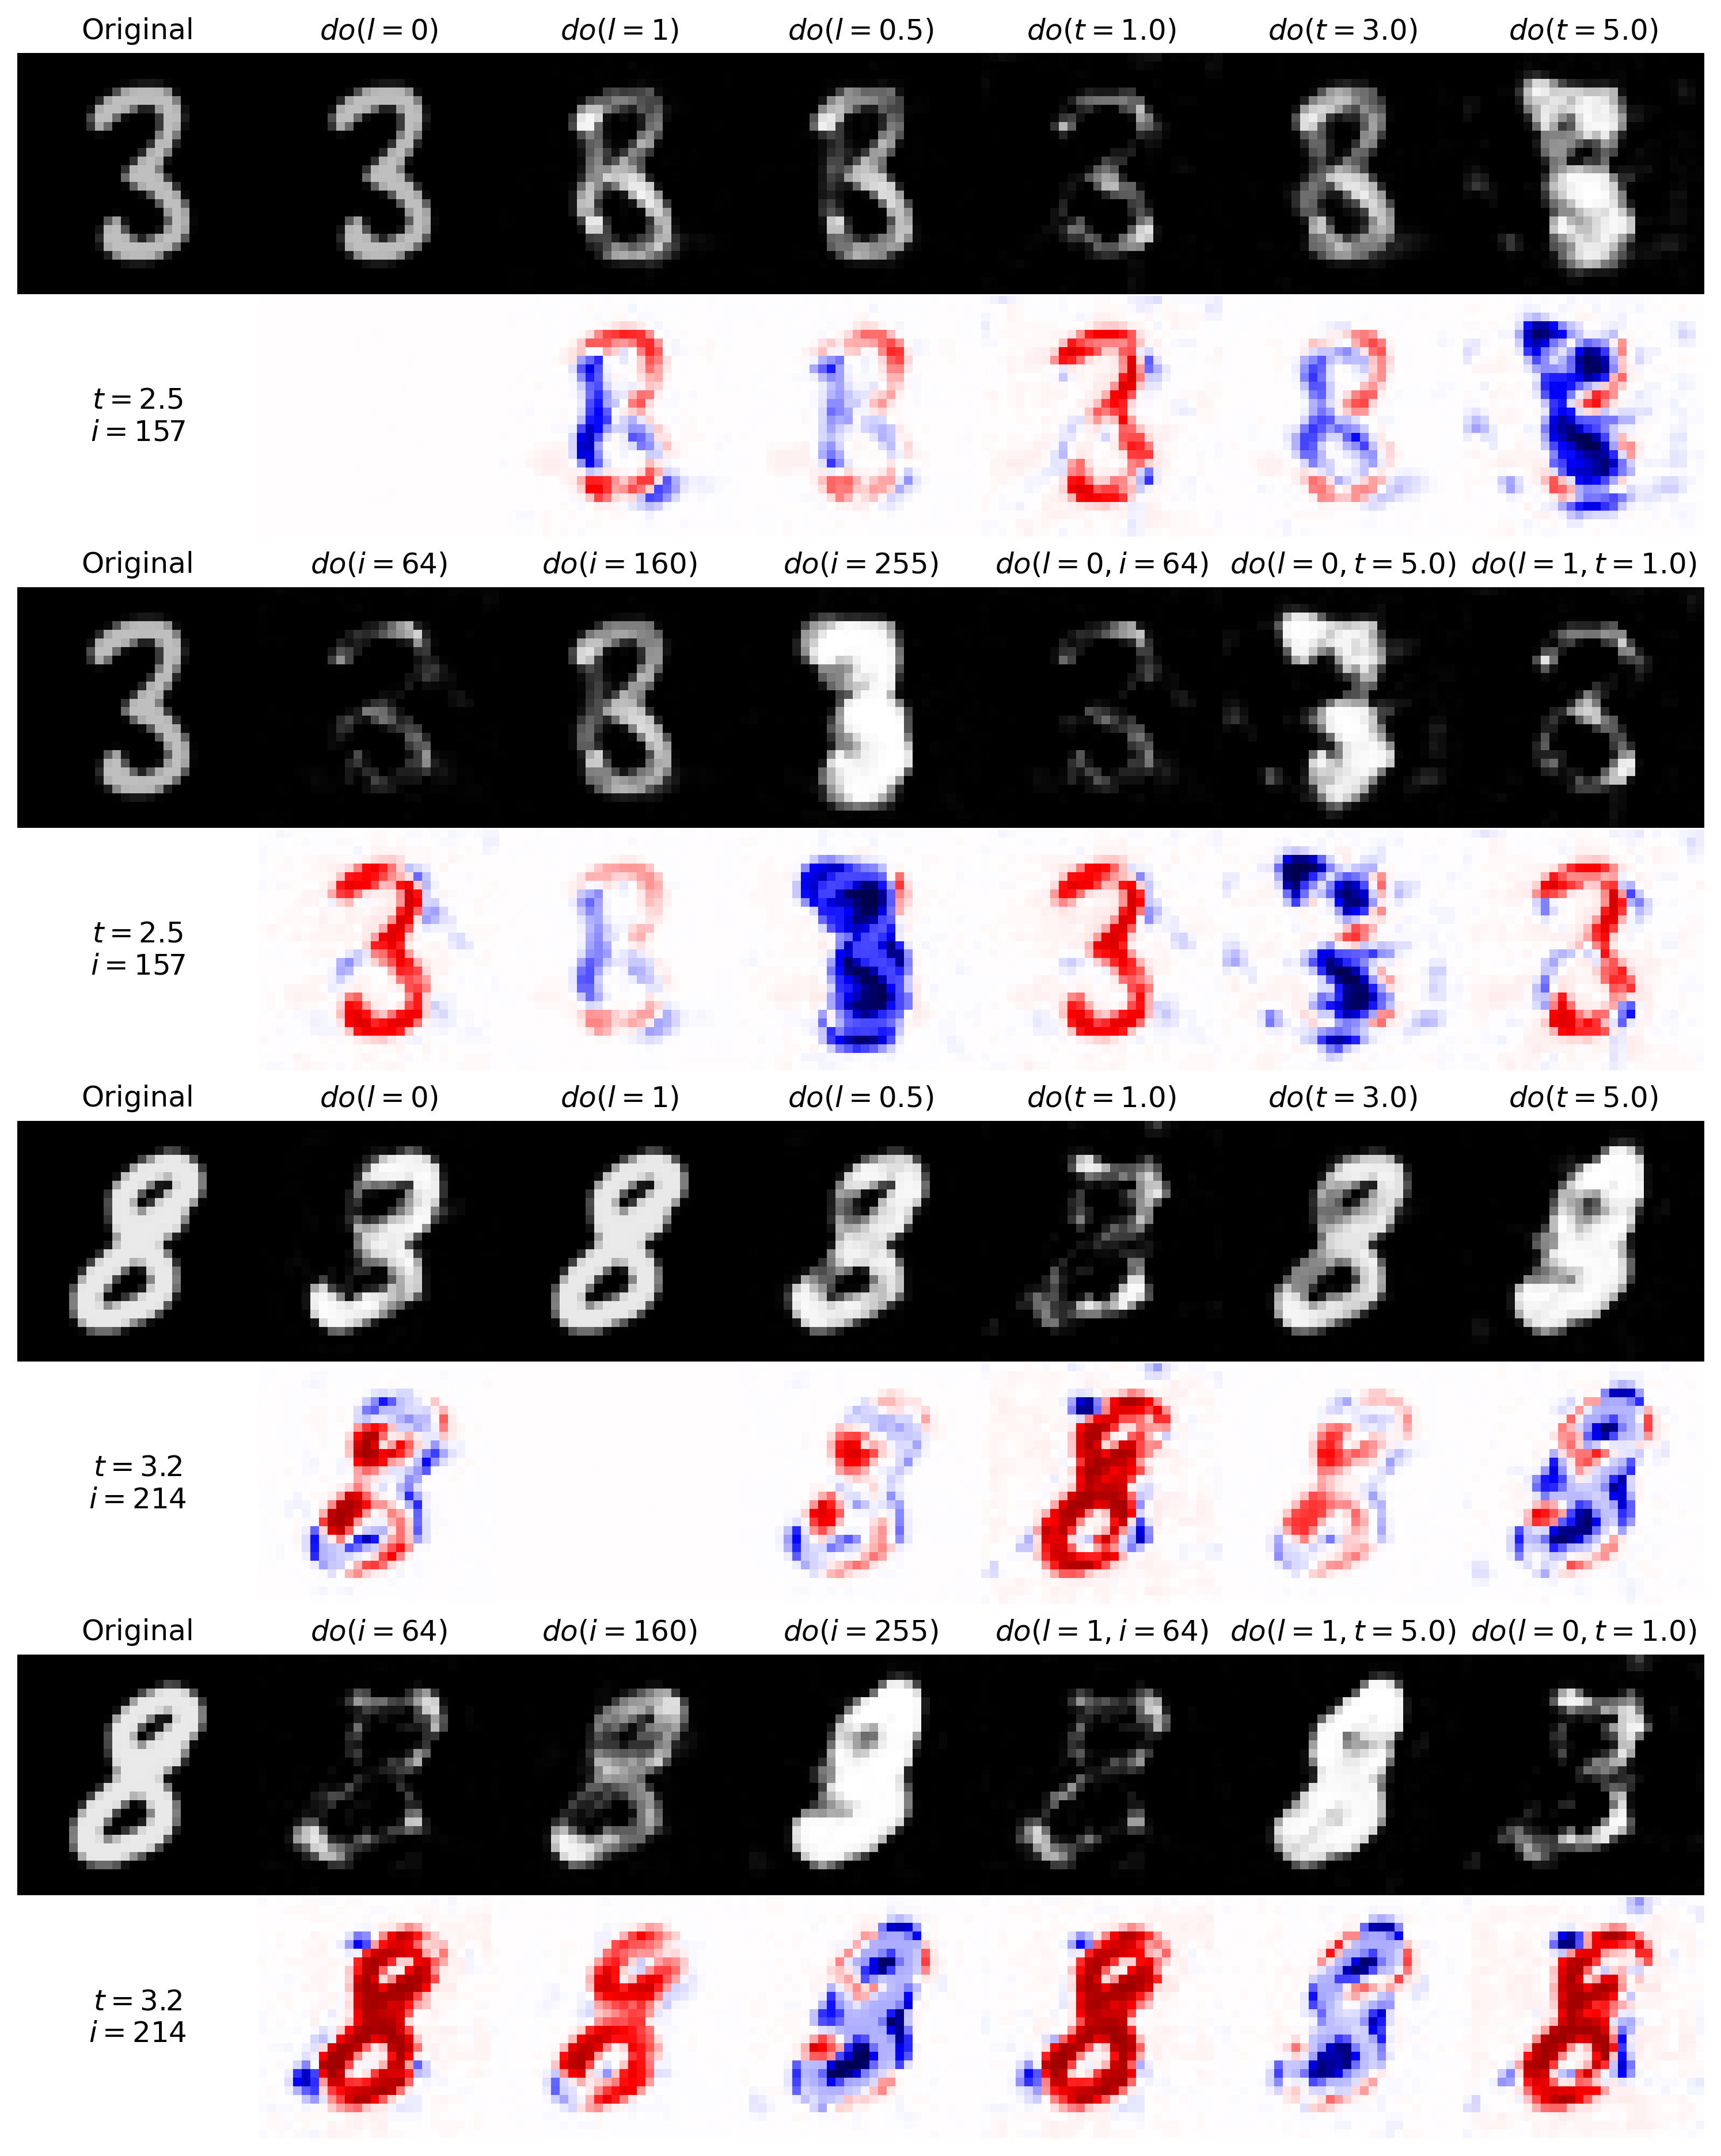

In [272]:
model_name = 140

interventions = [
    (50, [
        {'label': 0.},
        {'label': 1.},
        {'label': 0.5},
        {'thickness': 1.},
        {'thickness': 3.},
        {'thickness': 5.},
    ]),
    (50, [
        {'intensity': 64.},
        {'intensity': 160.},
        {'intensity': 255.},
        {'label': 0., 'intensity': 64.},
        {'label': 0., 'thickness': 5.},
        {'label': 1., 'thickness': 1.},
    ]),
    (13, [
        {'label': 0.},
        {'label': 1.},
        {'label': 0.5},
        {'thickness': 1.},
        {'thickness': 3.},
        {'thickness': 5.},
    ]),
    (13, [
        {'intensity': 64.},
        {'intensity': 160.},
        {'intensity': 255.},
        {'label': 1., 'intensity': 64.},
        {'label': 1., 'thickness': 5.},
        {'label': 0., 'thickness': 1.},
    ]),
]

save_name = 'counterfactual_range_140'

plot_gen_intervention_range(model_name, interventions, save_name, normalise_all=True, num_samples=32)

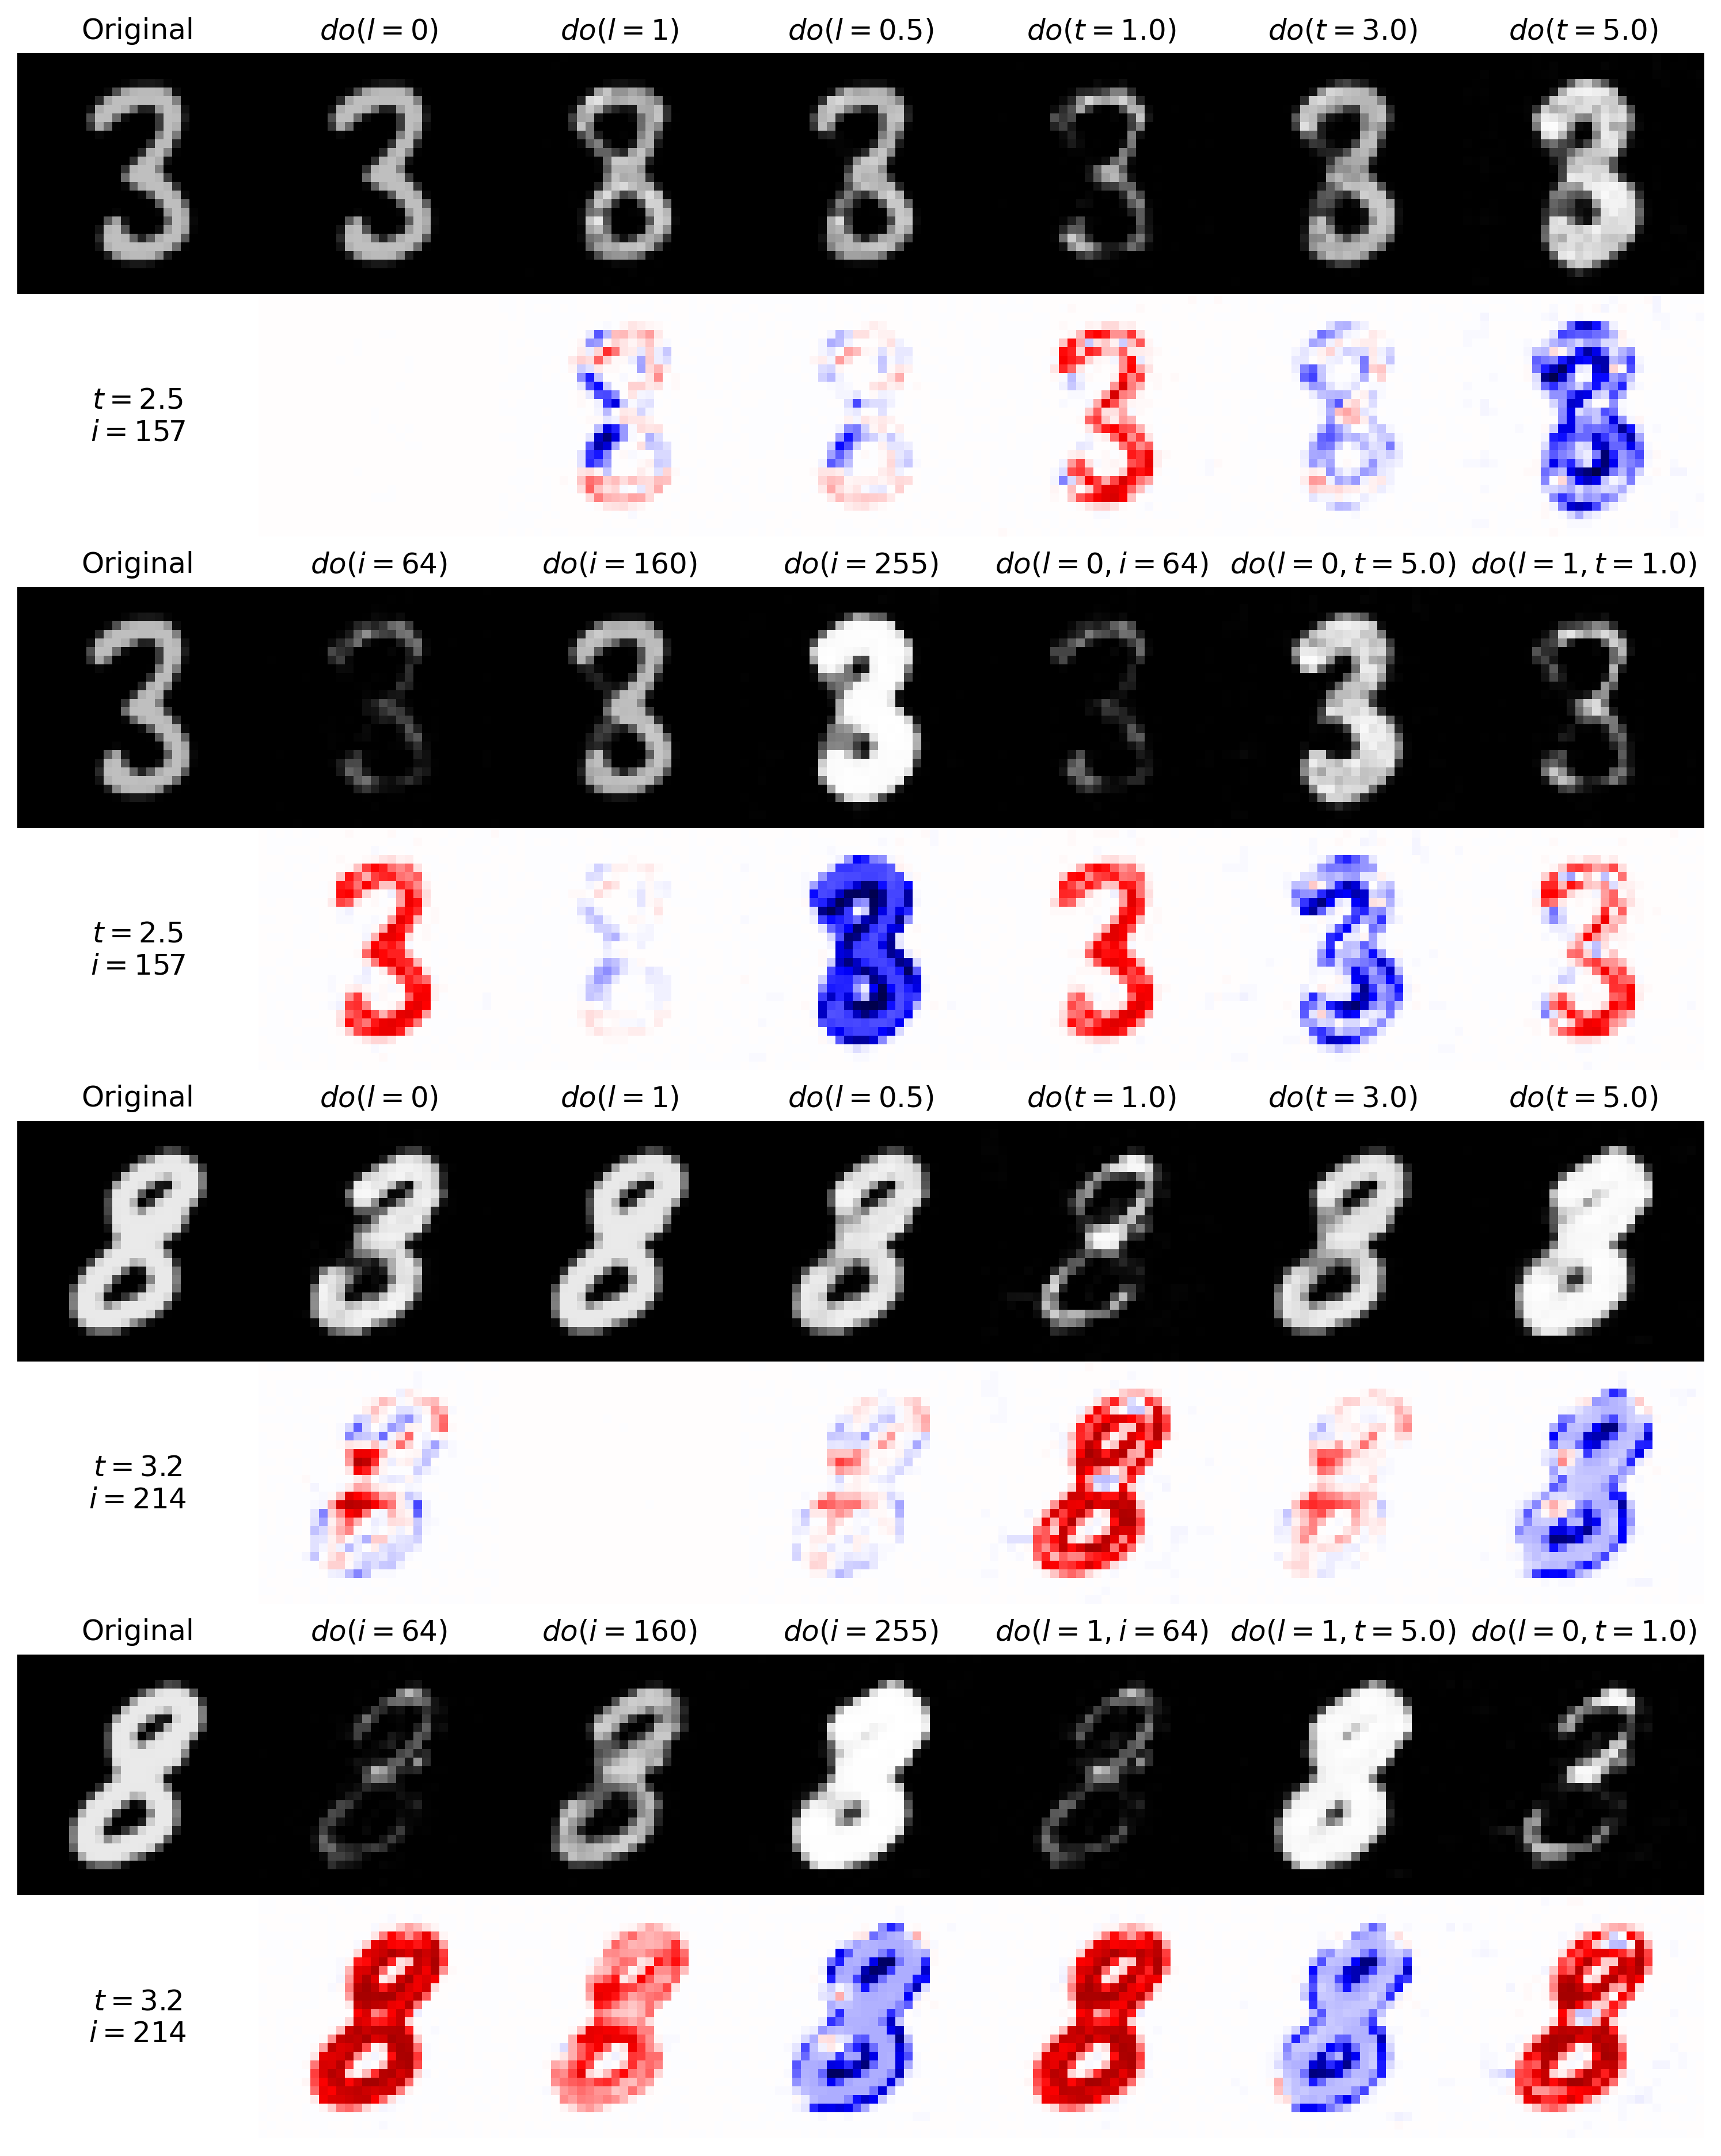

In [273]:
model_name = 131

interventions = [
    (50, [
        {'label': 0.},
        {'label': 1.},
        {'label': 0.5},
        {'thickness': 1.},
        {'thickness': 3.},
        {'thickness': 5.},
    ]),
    (50, [
        {'intensity': 64.},
        {'intensity': 160.},
        {'intensity': 255.},
        {'label': 0., 'intensity': 64.},
        {'label': 0., 'thickness': 5.},
        {'label': 1., 'thickness': 1.},
    ]),
    (13, [
        {'label': 0.},
        {'label': 1.},
        {'label': 0.5},
        {'thickness': 1.},
        {'thickness': 3.},
        {'thickness': 5.},
    ]),
    (13, [
        {'intensity': 64.},
        {'intensity': 160.},
        {'intensity': 255.},
        {'label': 1., 'intensity': 64.},
        {'label': 1., 'thickness': 5.},
        {'label': 0., 'thickness': 1.},
    ]),
]

save_name = 'counterfactual_range_131'

plot_gen_intervention_range(model_name, interventions, save_name, normalise_all=True, num_samples=32)